In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


In [10]:
from csgwsim import WaveForm as WF

/home/ekli/.local/lib/python3.9/site-packages/few-1.5.1-py3.9-linux-x86_64.egg/few/utils/utility.py:793: UserWarning: The file FluxNewMinusPNScaled_fixed_y_order.dat did not open sucessfully. It will now be downloaded to the proper location.
  warnings.warn(
--2023-09-18 17:32:08--  https://zenodo.org/record/3981654/files/FluxNewMinusPNScaled_fixed_y_order.dat
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61494 (60K) [application/octet-stream]
Saving to: ‘FluxNewMinusPNScaled_fixed_y_order.dat’

     0K .......... .......... .......... .......... .......... 83%  165K 0s
    50K ..........                                            100%  366M=0.3s

2023-09-18 17:32:11 (198 KB/s) - ‘FluxNewMinusPNScaled_fixed_y_order.dat’ saved [61494/61494]



This is waveform for GCB
Amplitude of GW is: 6.239929724534004e-25
Frequency and its derivative are:
            f0    = 0.001
            fdot  = 1.825583803423699e-18,
            fddot = 1.2220106152184107e-32


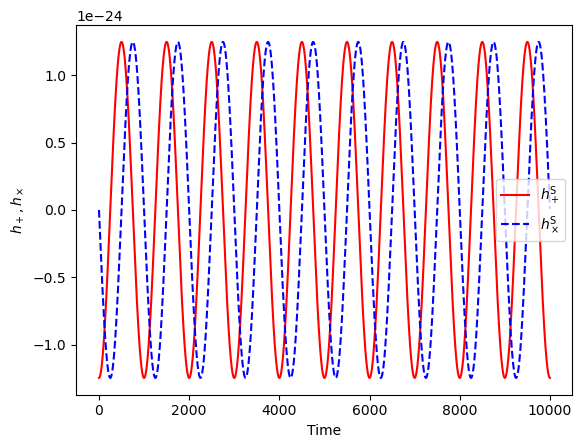

<Figure size 640x480 with 0 Axes>

In [15]:
%run test_GCB.py

In [12]:
WF.GCBWaveform

csgwsim.pyWaveForm.GCBWaveform

This is the BHB waveform
2592000
Time cost is 1.1798784732818604 s


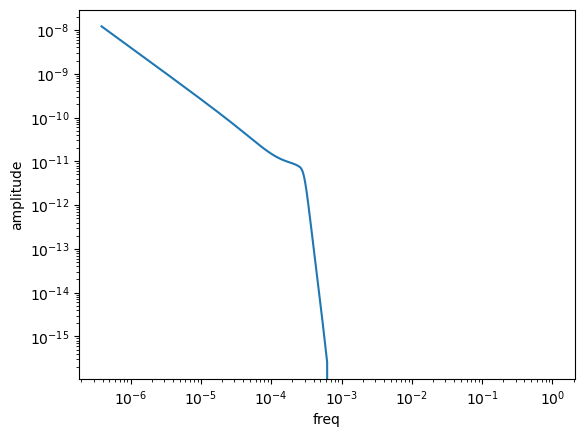

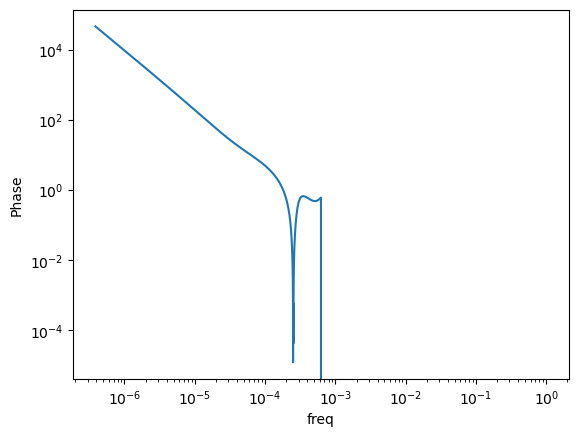

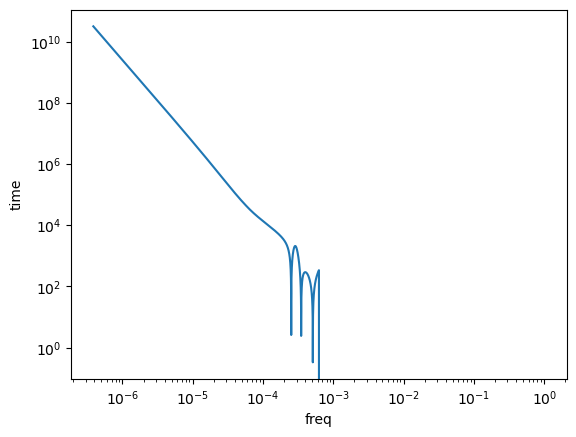

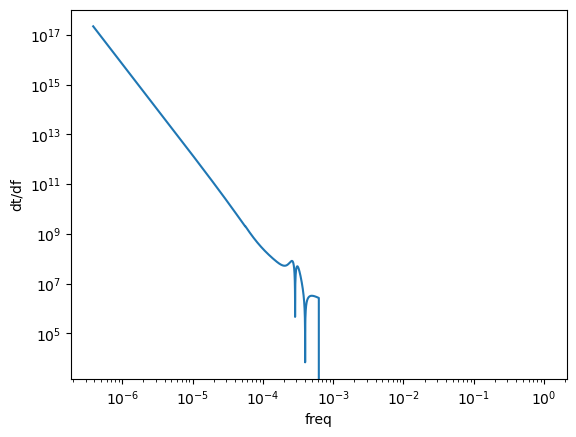

<Figure size 640x480 with 0 Axes>

In [6]:
%run BHB.py

In [12]:
Tobs = 4* DAY
T = Tobs/YRSID_SI
dt = 1
tf = np.arange(0,Tobs,dt)

In [20]:
tf

array([     0,      1,      2, ..., 345597, 345598, 345599])

In [21]:
np.linspace(0, Tobs, int(Tobs/dt))

array([0.00000000e+00, 1.00000289e+00, 2.00000579e+00, ...,
       3.45598000e+05, 3.45599000e+05, 3.45600000e+05])

In [22]:
tf.shape, tf[-1], T*YRSID_SI, Tobs, int(Tobs/dt)

((345600,), 345599, 345600.0, 345600, 345600)